<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/2D_shape_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

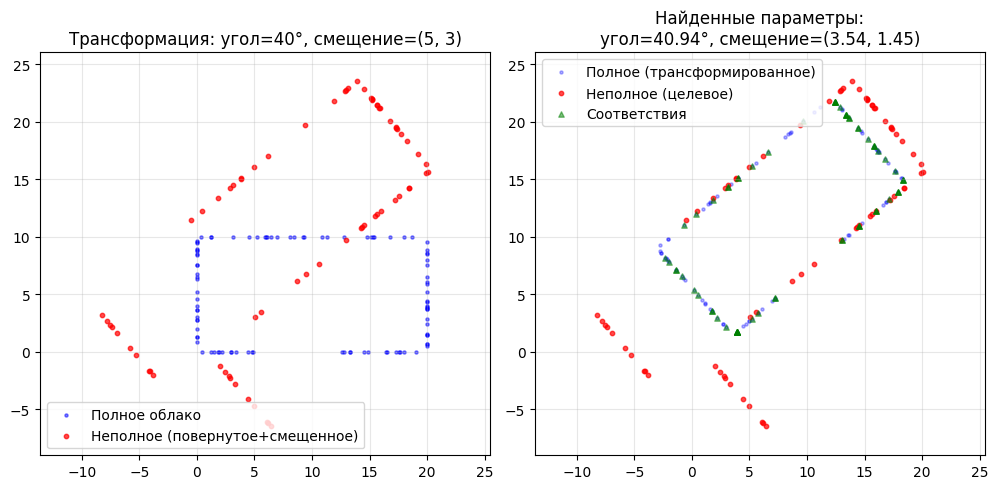

Истинные параметры:
  Угол: 40°
  Смещение: (5, 3)

Найденные параметры:
  Угол: 40.94°
  Смещение: (3.54, 1.45)

Ошибка выравнивания: 2.833685
Точек в полном облаке: 100
Точек в неполном облаке: 70


In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.optimize import minimize

def generate_lidar_points(width, height, n_points):
    """Генерирует случайные точки на периметре прямоугольника"""

    n_per_side = n_points // 4
    remainder = n_points % 4

    points = []

    # Нижняя сторона (y=0)
    x_bottom = np.random.uniform(0, width, n_per_side + (remainder > 0))
    points.extend(np.column_stack([x_bottom, np.zeros_like(x_bottom)]))

    # Правая сторона (x=width)
    y_right = np.random.uniform(0, height, n_per_side + (remainder > 1))
    points.extend(np.column_stack([np.full_like(y_right, width), y_right]))

    # Верхняя сторона (y=height)
    x_top = np.random.uniform(0, width, n_per_side + (remainder > 2))
    points.extend(np.column_stack([x_top, np.full_like(x_top, height)]))

    # Левая сторона (x=0)
    y_left = np.random.uniform(0, height, n_per_side)
    points.extend(np.column_stack([np.zeros_like(y_left), y_left]))

    return np.array(points)

def transform_points(points, angle, translation):
    """Поворачивает и смещает точки"""
    # Поворот
    rad = np.radians(angle)
    rot = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
    rotated = points @ rot.T
    # Смещение
    return rotated + translation

# Параметры
width, height = 20, 10
n_points_full = 100
n_points_incomplete = 70

# Генерация облаков точек
full_cloud = generate_lidar_points(width, height, n_points_full)
# incomplete_cloud = generate_lidar_points(width, height, n_points_incomplete)  # только часть точек

a = generate_lidar_points(width, height, n_points_incomplete)[0:50]
b = generate_lidar_points(width, height, n_points_incomplete)[60:70]
b = transform_points(b, 0, np.array([-5, -10]))
c = generate_lidar_points(width, height, n_points_incomplete)[60:70]
c = transform_points(b, 0, np.array([-5, 10]))
incomplete_cloud = np.vstack([a, b, c])

# Трансформация неполного облака (поворот + смещение)
true_angle = 40
true_translation = np.array([5, 3])
incomplete_transformed = transform_points(incomplete_cloud, true_angle, true_translation)

def add_random_points(points, n_points, x_range=(0, 20), y_range=(5, 20)):
    """
    Добавляет случайные точки к существующему массиву

    Parameters:
    points: исходный массив точек
    n_points: количество случайных точек для добавления
    x_range: диапазон x координат (min, max)
    y_range: диапазон y координат (min, max)
    """
    random_points = np.random.uniform(
        low=[x_range[0], y_range[0]],
        high=[x_range[1], y_range[1]],
        size=(n_points, 2)
    )
    return np.vstack([points, random_points])


# incomplete_transformed = add_random_points(incomplete_transformed, 30)

def alignment_error(params):
    """Ошибка выравнивания для заданных параметров трансформации"""
    angle, tx, ty = params
    transformed_full = transform_points(full_cloud, angle, np.array([tx, ty]))
    tree = KDTree(transformed_full)
    distances = tree.query(incomplete_transformed)[0]
    return np.mean(distances)

# Поиск оптимальных параметров
result = minimize(
    alignment_error,
    x0=[0, 0, 0],  # начальное приближение
    bounds=[(-180, 180), (-1000, 1000), (-20, 20)],  # границы поиска
    method='L-BFGS-B'
)

best_angle, best_tx, best_ty = result.x
best_translation = np.array([best_tx, best_ty])

# Визуализация
plt.figure(figsize=(15, 5))

# 1. Исходные облака
plt.subplot(131)
plt.scatter(full_cloud[:, 0], full_cloud[:, 1], c='blue', s=5, alpha=0.5, label='Полное облако')
plt.scatter(incomplete_transformed[:, 0], incomplete_transformed[:, 1],
           c='red', s=10, alpha=0.7, label='Неполное (повернутое+смещенное)')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.legend()
plt.title(f'Трансформация: угол={true_angle}°, смещение=({true_translation[0]}, {true_translation[1]})')

# 2. После трансформации неполного облака
plt.subplot(132)
transformed_full = transform_points(full_cloud, best_angle, best_translation)
plt.scatter(transformed_full[:, 0], transformed_full[:, 1], c='blue', s=5, alpha=0.3, label='Полное (трансформированное)')
plt.scatter(incomplete_transformed[:, 0], incomplete_transformed[:, 1],
           c='red', s=10, alpha=0.7, label='Неполное (целевое)')

# Находим соответствия
tree = KDTree(transformed_full)
distances, indices = tree.query(incomplete_transformed)
plt.scatter(transformed_full[indices, 0], transformed_full[indices, 1],
           c='green', s=15, alpha=0.5, marker='^', label='Соответствия')

plt.axis('equal')
plt.grid(alpha=0.3)
plt.legend()
plt.title(f'Найденные параметры:\nугол={best_angle:.2f}°, смещение=({best_tx:.2f}, {best_ty:.2f})')

plt.tight_layout()
plt.show()

print("Истинные параметры:")
print(f"  Угол: {true_angle}°")
print(f"  Смещение: ({true_translation[0]}, {true_translation[1]})")
print("\nНайденные параметры:")
print(f"  Угол: {best_angle:.2f}°")
print(f"  Смещение: ({best_tx:.2f}, {best_ty:.2f})")
print(f"\nОшибка выравнивания: {alignment_error(result.x):.6f}")
print(f"Точек в полном облаке: {len(full_cloud)}")
print(f"Точек в неполном облаке: {len(incomplete_transformed)}")

Способ 1: Фильтрация после предварительного выравнивания
Грубая оценка: угол=29.05°, tx=1.77, ty=3.15
Порог: 1.0
Оставлено точек: 50 из 70
Мин расстояние: 0.007, макс: 12.447, среднее: 3.077


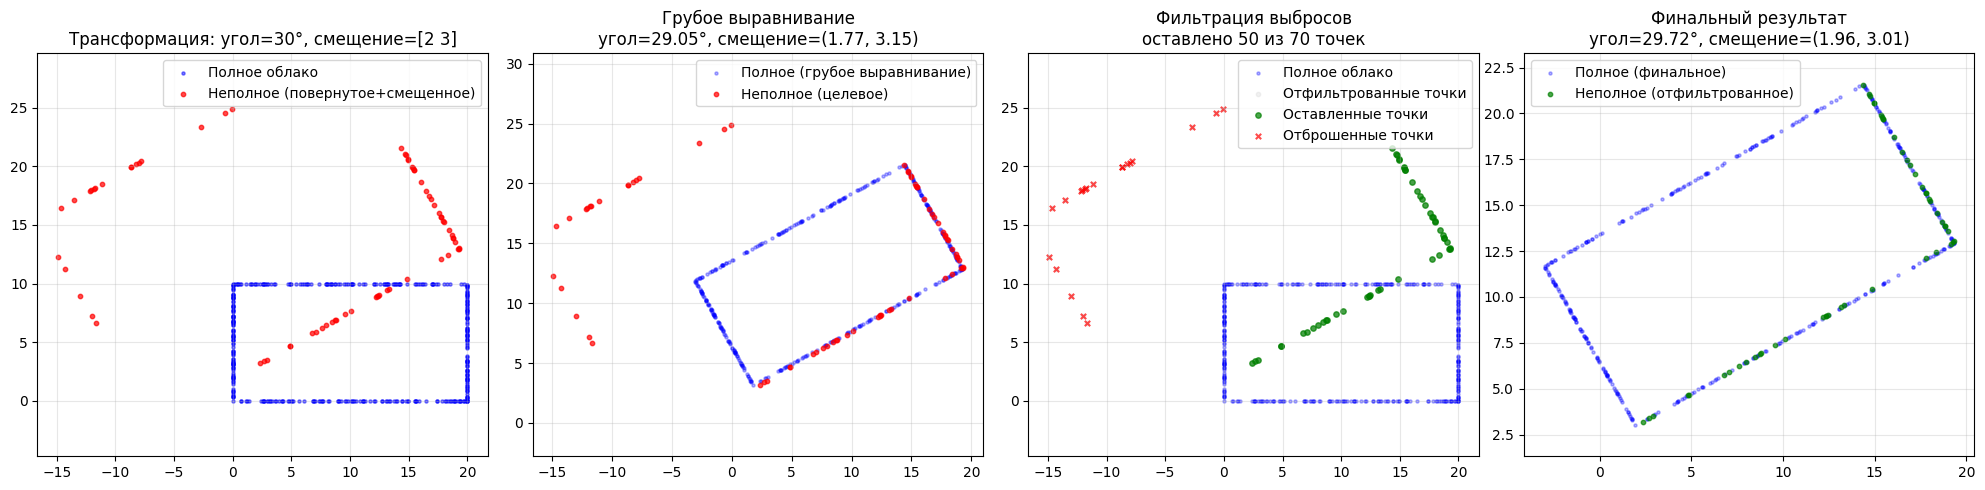


Истинные параметры:
  Угол: 30°
  Смещение: (2, 3)

Найденные параметры:
  Угол: 29.72°
  Смещение: (1.96, 3.01)


In [241]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.optimize import minimize

def generate_lidar_points(width, height, n_points):
    """Генерирует случайные точки на периметре прямоугольника"""
    n_per_side = n_points // 4
    remainder = n_points % 4

    points = []

    # Нижняя сторона (y=0)
    x_bottom = np.random.uniform(0, width, n_per_side + (remainder > 0))
    points.extend(np.column_stack([x_bottom, np.zeros_like(x_bottom)]))

    # Правая сторона (x=width)
    y_right = np.random.uniform(0, height, n_per_side + (remainder > 1))
    points.extend(np.column_stack([np.full_like(y_right, width), y_right]))

    # Верхняя сторона (y=height)
    x_top = np.random.uniform(0, width, n_per_side + (remainder > 2))
    points.extend(np.column_stack([x_top, np.full_like(x_top, height)]))

    # Левая сторона (x=0)
    y_left = np.random.uniform(0, height, n_per_side)
    points.extend(np.column_stack([np.zeros_like(y_left), y_left]))

    return np.array(points)

def transform_points(points, angle, translation):
    """Поворачивает и смещает точки"""
    rad = np.radians(angle)
    rot = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
    rotated = points @ rot.T
    return rotated + translation

# Параметры
width, height = 20, 10
n_points_full = 400
n_points_incomplete = 100

# Генерация облаков точек
full_cloud = generate_lidar_points(width, height, n_points_full)

# Создаем неполное облако с выбросами
a = generate_lidar_points(width, height, n_points_incomplete)[0:50]  # основные точки
b = generate_lidar_points(width, height, n_points_incomplete)[60:80]
b = transform_points(b, 0, np.array([-10, 10]))  # выбросы слева
incomplete_cloud = np.vstack([a, b])

# Трансформация неполного облака (поворот + смещение)
true_angle = 30
true_translation = np.array([2, 3])
incomplete_transformed = transform_points(incomplete_cloud, true_angle, true_translation)

def filter_outliers_by_distance(source_points, target_points, threshold, initial_guess=None):
    """
    Фильтрует выбросы, предварительно выравнивая облака

    Parameters:
    source_points: точки, которые нужно отфильтровать
    target_points: референсные точки
    threshold: максимальное расстояние до ближайшего соседа
    initial_guess: начальное приближение для выравнивания [angle, tx, ty]
    """
    if initial_guess is not None:
        # Предварительно трансформируем target_points для грубого выравнивания
        angle, tx, ty = initial_guess
        aligned_target = transform_points(target_points, angle, np.array([tx, ty]))
    else:
        aligned_target = target_points

    # Фильтрация
    tree = KDTree(aligned_target)
    distances, _ = tree.query(source_points)

    filtered_indices = distances < threshold
    filtered_points = source_points[filtered_indices]

    print(f"Порог: {threshold}")
    print(f"Оставлено точек: {len(filtered_points)} из {len(source_points)}")
    print(f"Мин расстояние: {distances.min():.3f}, макс: {distances.max():.3f}, среднее: {distances.mean():.3f}")

    return filtered_points, filtered_indices

# Способ 1: Фильтрация после грубой оценки (рекомендуется)
print("Способ 1: Фильтрация после предварительного выравнивания")

# Сначала делаем грубое выравнивание со всеми точками
def alignment_error_all(params):
    angle, tx, ty = params
    transformed_full = transform_points(full_cloud, angle, np.array([tx, ty]))
    tree = KDTree(transformed_full)
    distances = tree.query(incomplete_transformed)[0]
    return np.mean(distances)

# Поиск грубых параметров
result_initial = minimize(
    alignment_error_all,
    x0=[0, 0, 0],
    bounds=[(-180, 180), (-100, 100), (-100, 100)],
    method='L-BFGS-B'
)

print(f"Грубая оценка: угол={result_initial.x[0]:.2f}°, tx={result_initial.x[1]:.2f}, ty={result_initial.x[2]:.2f}")

# Фильтруем точки, используя грубую оценку для выравнивания
filtered_incomplete, filtered_indices = filter_outliers_by_distance(
    incomplete_transformed,
    full_cloud,
    threshold=1.0,
    initial_guess=result_initial.x
)

# Уточненный поиск с отфильтрованными точками
def alignment_error_filtered(params):
    angle, tx, ty = params
    transformed_full = transform_points(full_cloud, angle, np.array([tx, ty]))
    tree = KDTree(transformed_full)
    distances = tree.query(filtered_incomplete)[0]
    return np.mean(distances)

result_filtered = minimize(
    alignment_error_filtered,
    x0=result_initial.x,  # используем грубую оценку как начальное приближение
    bounds=[(-180, 180), (-100, 100), (-100, 100)],
    method='L-BFGS-B'
)

best_angle, best_tx, best_ty = result_filtered.x
best_translation = np.array([best_tx, best_ty])

# Визуализация
plt.figure(figsize=(20, 5))

# 1. Исходные облака
plt.subplot(141)
plt.scatter(full_cloud[:, 0], full_cloud[:, 1], c='blue', s=5, alpha=0.5, label='Полное облако')
plt.scatter(incomplete_transformed[:, 0], incomplete_transformed[:, 1],
           c='red', s=10, alpha=0.7, label='Неполное (повернутое+смещенное)')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.legend()
plt.title(f'Трансформация: угол={true_angle}°, смещение={true_translation}')

# 2. Результат грубого выравнивания
plt.subplot(142)
transformed_full_initial = transform_points(full_cloud, result_initial.x[0],
                                           np.array([result_initial.x[1], result_initial.x[2]]))
plt.scatter(transformed_full_initial[:, 0], transformed_full_initial[:, 1],
           c='blue', s=5, alpha=0.3, label='Полное (грубое выравнивание)')
plt.scatter(incomplete_transformed[:, 0], incomplete_transformed[:, 1],
           c='red', s=10, alpha=0.7, label='Неполное (целевое)')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.legend()
plt.title(f'Грубое выравнивание\nугол={result_initial.x[0]:.2f}°, смещение=({result_initial.x[1]:.2f}, {result_initial.x[2]:.2f})')

# 3. Отфильтрованные точки
plt.subplot(143)
plt.scatter(full_cloud[:, 0], full_cloud[:, 1], c='blue', s=5, alpha=0.3, label='Полное облако')
plt.scatter(incomplete_transformed[:, 0], incomplete_transformed[:, 1],
           c='lightgray', s=10, alpha=0.3, label='Отфильтрованные точки')
plt.scatter(incomplete_transformed[filtered_indices, 0], incomplete_transformed[filtered_indices, 1],
           c='green', s=15, alpha=0.7, label='Оставленные точки')
plt.scatter(incomplete_transformed[~filtered_indices, 0] if any(~filtered_indices) else [],
           incomplete_transformed[~filtered_indices, 1] if any(~filtered_indices) else [],
           c='red', s=15, alpha=0.7, marker='x', label='Отброшенные точки')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.legend()
plt.title(f'Фильтрация выбросов\nоставлено {sum(filtered_indices)} из {len(filtered_indices)} точек')

# 4. Финальный результат
plt.subplot(144)
transformed_full_final = transform_points(full_cloud, best_angle, best_translation)
plt.scatter(transformed_full_final[:, 0], transformed_full_final[:, 1],
           c='blue', s=5, alpha=0.3, label='Полное (финальное)')
plt.scatter(incomplete_transformed[filtered_indices, 0], incomplete_transformed[filtered_indices, 1],
           c='green', s=10, alpha=0.7, label='Неполное (отфильтрованное)')

plt.axis('equal')
plt.grid(alpha=0.3)
plt.legend()
plt.title(f'Финальный результат\nугол={best_angle:.2f}°, смещение=({best_tx:.2f}, {best_ty:.2f})')

plt.tight_layout()
plt.show()

print("\nИстинные параметры:")
print(f"  Угол: {true_angle}°")
print(f"  Смещение: ({true_translation[0]}, {true_translation[1]})")
print("\nНайденные параметры:")
print(f"  Угол: {best_angle:.2f}°")
print(f"  Смещение: ({best_tx:.2f}, {best_ty:.2f})")